## Prepare

In [1]:
import math
import re
import string
import random
from collections import Counter, OrderedDict
from functools import lru_cache
from pprint import pprint


import numpy as np
import matplotlib.pyplot as plt
import pyarabic.araby as araby
from beautifultable import BeautifulTable
from datasets import Dataset, load_dataset
from scipy.stats import linregress
from tqdm.auto import tqdm

In [2]:
random.seed(42)

In [3]:
# %cd ../../..

In [4]:
from dotless_arabic.datasets.utils import calculate_entropy
from dotless_arabic.processing import process, undot

[2024-05-10 16:55:36,483 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [5]:
ENGLISH_LETTERS = string.ascii_lowercase

In [6]:
def process_english(text):
    # add spaces between punctuations, if there is not
    text = text.lower()
    text = re.sub(
        r"""([.,!?()\/\\،"'\{\}\(\)\[\]؟<>`؛=+\-\*\&\^\%\$\#\@\!])""",
        r" \1 ",
        text,
    )
    # remove any non arabic character
    text = "".join(
        [c for c in text if c in ENGLISH_LETTERS or c.isspace()]
    )  # keep only english chars and spaces
    text = re.sub("\s{2,}", " ", text).strip()  # remove multiple spaces
    """
      interestingly, there is a difference betwen re.sub('\s+',' ',s) and re.sub('\s{2,}',' ',s)
      the first one remove newlines while the second does not.
    """
    return text.strip()

In [7]:
un_dataset = load_dataset("un_multi", "ar-en")
un_dataset = un_dataset["train"].filter(
    lambda example: example["translation"]["en"] and example["translation"]["ar"]
)


def prepare_corpus(example):
    example["processed_english_un"] = process_english(example["translation"]["en"])
    example["processed_arabic_un"] = process(example["translation"]["ar"])
    example["undotted_processed_arabic_un"] = undot(example["processed_arabic_un"])
    return example


un_dataset = un_dataset.map(prepare_corpus, num_proc=4)

Resolving data files:   0%|          | 0/147 [00:00<?, ?it/s]

Map (num_proc=4):   0%|          | 0/9759125 [00:00<?, ? examples/s]

In [8]:
len(un_dataset)

9759125

In [9]:
english_un = list(un_dataset["processed_english_un"])
english_un[:10]

['new york may',
 'statement by the delegation of malaysia on behalf of the group of non aligned states parties to the treaty on the non proliferation of nuclear weapons at the plenary of the review conference of the parties to the treaty on the non proliferation of nuclear weapons concerning the adoption of the agenda new york may',
 'the non aligned states parties to the npt welcome the adoption of the agenda of the review conference of the parties to the npt',
 'the agenda establishes the framework for conducting the review of the operation of the treaty in accordance with article viii paragraph of the treaty the decisions and the resolution of previous conferences in particular the review and extension conference and the decision of the review conference to adopt by consensus its final document',
 'the non aligned states parties to the npt reaffirm their commitment to implement in good faith their obligations under the treaty as well as all the commitments agreed upon by consensus 

In [10]:
print(len(english_un))

9759125


In [11]:
arabic_un = list(un_dataset["processed_arabic_un"])
arabic_un[:10]

['نيويورك ايار مايو',
 'بيان مقدم من وفد ماليزيا باسم مجموعة دول عدم الانحياز الاطراف في معاهدة عدم انتشار الاسلحة النووية في الجلسة العامة لموتمر الاطراف في معاهدة عدم انتشار الاسلحة النووية لاستعراض المعاهدة عام بشان اقرار جدول الاعمال نيويورك ايار مايو',
 'ترحب دول عدم الانحياز الاطراف في معاهدة عدم انتشار الاسلحة النووية باقرار جدول اعمال موتمر الاطراف في معاهدة عدم انتشار الاسلحة النووية لاستعراض المعاهدة عام',
 'ويحدد الجدول اطار اجراء استعراض سير المعاهدة وفقا للفقرة من المادة الثامنة من المعاهدة وقرار ومقررات الموتمرات السابقة لا سيما موتمر عام لاستعراض المعاهدة وتمديدها والمقرر الذي اتخذه موتمر الاستعراض في عام باعتماد وثيقته الختامية بتوافق الاراء',
 'وتوكد دول عدم الانحياز الاطراف في معاهدة عدم انتشار الاسلحة النووية من جديد تعهدها بحسن نية بتنفيذ واجباتها بموجب المعاهدة فضلا عن جميع الالتزامات المتفق عليها بتوافق الاراء في موتمري استعراض المعاهدة في عامي و',
 'وتحث دول عدم الانحياز الاطراف في معاهدة عدم انتشار الاسلحة النووية جميع الدول الاطراف على تنفيذ واجباتها والتزاماته

In [12]:
print(len(arabic_un))

9759125


In [13]:
undotted_arabic_un = list(un_dataset["undotted_processed_arabic_un"])
undotted_arabic_un[:10]

['ٮٮوٮورك اٮار ماٮو',
 'ٮٮاں مڡدم مں وڡد مالٮرٮا ٮاسم محموعه دول عدم الاٮحٮار الاطراڡ ڡى معاهده عدم اٮٮسار الاسلحه الٮووٮه ڡى الحلسه العامه لموٮمر الاطراڡ ڡى معاهده عدم اٮٮسار الاسلحه الٮووٮه لاسٮعراص المعاهده عام ٮساں اڡرار حدول الاعمال ٮٮوٮورك اٮار ماٮو',
 'ٮرحٮ دول عدم الاٮحٮار الاطراڡ ڡى معاهده عدم اٮٮسار الاسلحه الٮووٮه ٮاڡرار حدول اعمال موٮمر الاطراڡ ڡى معاهده عدم اٮٮسار الاسلحه الٮووٮه لاسٮعراص المعاهده عام',
 'وٮحدد الحدول اطار احراء اسٮعراص سٮر المعاهده وڡڡا للڡڡره مں الماده الٮامٮه مں المعاهده وڡرار ومڡرراٮ الموٮمراٮ الساٮڡه لا سٮما موٮمر عام لاسٮعراص المعاهده وٮمدٮدها والمڡرر الدى اٮحده موٮمر الاسٮعراص ڡى عام ٮاعٮماد وٮٮڡٮه الحٮامٮه ٮٮواڡٯ الاراء',
 'وٮوكد دول عدم الاٮحٮار الاطراڡ ڡى معاهده عدم اٮٮسار الاسلحه الٮووٮه مں حدٮد ٮعهدها ٮحسں ٮٮه ٮٮٮڡٮد واحٮاٮها ٮموحٮ المعاهده ڡصلا عں حمٮع الالٮراماٮ المٮڡٯ علٮها ٮٮواڡٯ الاراء ڡى موٮمرى اسٮعراص المعاهده ڡى عامى و',
 'وٮحٮ دول عدم الاٮحٮار الاطراڡ ڡى معاهده عدم اٮٮسار الاسلحه الٮووٮه حمٮع الدول الاطراڡ على ٮٮڡٮد واحٮاٮها والٮراماٮه

In [14]:
print(len(undotted_arabic_un))

9759125


# Functions

In [15]:
@lru_cache()
def characters_counter(dataset, use_tqdm=True):
    dataset = tqdm(dataset) if use_tqdm else dataset
    return Counter(character for item in dataset for word in item.split() for character in word)


@lru_cache()
def words_counter(dataset, use_tqdm=True):
    dataset = tqdm(dataset) if use_tqdm else dataset
    return Counter(word for item in dataset for word in item.split())


def characters_analysis(dataset, print_counter=False):
    counter = characters_counter(tuple(dataset))
    if print_counter:
        pprint(counter)
    unique_characters_count = len(counter.keys())
    print("unique characters count:", f"{unique_characters_count:,}")
    return unique_characters_count


def words_analysis(dataset, top_freq=100):
    counter = words_counter(tuple(dataset))
    words_count = sum(counter.values())
    unique_words_count = len(counter.keys())
    counter = OrderedDict(counter.most_common(top_freq))
    pprint(counter)
    print("words count:", f"{words_count:,}")
    return unique_words_count


def characters_entropy(dataset):
    counter = characters_counter(tuple(dataset))
    return calculate_entropy(counter)


def words_entropy(dataset):
    counter = words_counter(tuple(dataset))
    return calculate_entropy(counter)

In [16]:
# we may need to report the error on the regression line: MSE, MAE, etc.
@lru_cache()
def get_heaps_law_constants(dataset, get_points_list=False, clear_lru_cache=False):
    X, Y = [], []
    vocabulary = set()
    number_of_tokens = 0
    for index in tqdm(range(len(dataset))):
        counter = words_counter(
            tuple([dataset[index]]),
            use_tqdm=False,
        )

        number_of_tokens += sum(counter.values())
        X.append(
            math.log(
                number_of_tokens,
                math.e,  # base
            ),
        )

        vocabulary.update(counter.keys())
        Y.append(
            math.log(
                len(vocabulary),
                math.e,  # base
            ),
        )

        if clear_lru_cache:
            words_counter.cache_clear()

    slope, intercept, *_ = linregress(X, Y)

    b = slope
    k = math.e**intercept

    if get_points_list:
        return b, k, (X, Y)
    return b, k

In [17]:
def get_zipf_constants(counter):
    heighest_frequency = counter.most_common(1)[-1][1]
    X = np.log(heighest_frequency) * np.log((np.arange(len(counter)) + 1))
    Y = np.log(np.array(list(counter.values())))
    slope, intercept, *_ = linregress(X, Y)
    return np.exp(slope), np.exp(intercept)

# Descriptive Statistics

In [18]:
random.shuffle(english_un)
random.shuffle(arabic_un)
random.shuffle(undotted_arabic_un)

In [19]:
# english un
english_un_unique_characters = len(characters_counter(dataset=tuple(english_un)).keys())
english_un_all_characters = sum(characters_counter(dataset=tuple(english_un)).values())
english_un_characters_entropy = characters_entropy(dataset=tuple(english_un))

english_un_unique_words = len(words_counter(dataset=tuple(english_un)).keys())
english_un_all_words = sum(words_counter(dataset=tuple(english_un)).values())
english_un_words_entropy = words_entropy(dataset=tuple(english_un))

(
    english_un_heaps_beta,
    english_un_heaps_k,
    (english_un_heaps_X, english_un_heaps_Y),
) = get_heaps_law_constants(dataset=tuple(english_un), get_points_list=True)


# arabic un

arabic_un_unique_characters = len(characters_counter(dataset=tuple(arabic_un)).keys())
arabic_un_all_characters = sum(characters_counter(dataset=tuple(arabic_un)).values())
arabic_un_characters_entropy = characters_entropy(dataset=tuple(arabic_un))

arabic_un_unique_words = len(words_counter(dataset=tuple(arabic_un)).keys())
arabic_un_all_words = sum(words_counter(dataset=tuple(arabic_un)).values())
arabic_un_words_entropy = words_entropy(dataset=tuple(arabic_un))

(
    arabic_un_heaps_beta,
    arabic_un_heaps_k,
    (arabic_un_heaps_X, arabic_un_heaps_Y),
) = get_heaps_law_constants(dataset=tuple(arabic_un), get_points_list=True)


# undotted arabic un

undotted_arabic_un_unique_characters = len(
    characters_counter(dataset=tuple(undotted_arabic_un)).keys()
)
undotted_arabic_un_all_characters = sum(
    characters_counter(dataset=tuple(undotted_arabic_un)).values()
)
undotted_arabic_un_characters_entropy = characters_entropy(
    dataset=tuple(undotted_arabic_un)
)

undotted_arabic_un_unique_words = len(
    words_counter(dataset=tuple(undotted_arabic_un)).keys()
)
undotted_arabic_un_all_words = sum(
    words_counter(dataset=tuple(undotted_arabic_un)).values()
)
undotted_arabic_un_words_entropy = words_entropy(dataset=tuple(undotted_arabic_un))

(
    undotted_arabic_un_heaps_beta,
    undotted_arabic_un_heaps_k,
    (undotted_arabic_un_heaps_X, undotted_arabic_un_heaps_Y),
) = get_heaps_law_constants(dataset=tuple(undotted_arabic_un), get_points_list=True)

  0%|          | 0/9759125 [00:00<?, ?it/s]

  0%|          | 0/9759125 [00:00<?, ?it/s]

  0%|          | 0/9759125 [00:00<?, ?it/s]

  0%|          | 0/9759125 [00:01<?, ?it/s]

  0%|          | 0/9759125 [00:00<?, ?it/s]

  0%|          | 0/9759125 [00:01<?, ?it/s]

  0%|          | 0/9759125 [00:00<?, ?it/s]

  0%|          | 0/9759125 [00:00<?, ?it/s]

  0%|          | 0/9759125 [00:00<?, ?it/s]

  0%|          | 0/9759125 [00:02<?, ?it/s]

  0%|          | 0/9759125 [00:00<?, ?it/s]

  0%|          | 0/9759125 [00:00<?, ?it/s]

  0%|          | 0/9759125 [00:00<?, ?it/s]

  0%|          | 0/9759125 [00:02<?, ?it/s]

  0%|          | 0/9759125 [00:00<?, ?it/s]

In [20]:
chars_analysis_table = BeautifulTable(maxwidth=300)
chars_analysis_table.columns.header = [
    "dataset",
    "unique \n chars",
    "all \n chars",
    "chars \n entropy",
    "unique \n words (V)",
    "all \n words (N)",
    "words \n entropy",
    "Heaps law \n (b,k) constants",
]
chars_analysis_table.rows.append(
    [
        "english un",
        f"{english_un_unique_characters:,}",
        f"{english_un_all_characters:,}",
        f"{english_un_characters_entropy:,}",
        f"{english_un_unique_words:,}",
        f"{english_un_all_words:,}",
        f"{english_un_words_entropy}",
        f"({english_un_heaps_beta:.3f},{english_un_heaps_k:.3f})",
    ]
)
chars_analysis_table.rows.append(
    [
        "arabic un",
        f"{arabic_un_unique_characters:,}",
        f"{arabic_un_all_characters:,}",
        f"{arabic_un_characters_entropy:,}",
        f"{arabic_un_unique_words:,}",
        f"{arabic_un_all_words:,}",
        f"{arabic_un_words_entropy}",
        f"({arabic_un_heaps_beta:.3f},{arabic_un_heaps_k:.3f})",
    ]
)

chars_analysis_table.rows.append(
    [
        "undotted arabic un",
        f"{undotted_arabic_un_unique_characters:,}",
        f"{undotted_arabic_un_all_characters:,}",
        f"{undotted_arabic_un_characters_entropy:,}",
        f"{undotted_arabic_un_unique_words:,}",
        f"{undotted_arabic_un_all_words:,}",
        f"{undotted_arabic_un_words_entropy}",
        f"({undotted_arabic_un_heaps_beta:.3f},{undotted_arabic_un_heaps_k:.3f})",
    ]
)


print(chars_analysis_table)

+--------------------+---------+---------------+----------+------------+-------------+----------+------------------+
|      dataset       | unique  |     all       |  chars   |  unique    |    all      |  words   |    Heaps law     |
|                    |  chars  |     chars     |  entropy |  words (V) |  words (N)  |  entropy |  (b,k) constants |
+--------------------+---------+---------------+----------+------------+-------------+----------+------------------+
|     english un     |   26    | 1,337,121,519 |  4.121   |  272,567   | 248,442,788 |  9.701   |  (0.438,57.724)  |
+--------------------+---------+---------------+----------+------------+-------------+----------+------------------+
|     arabic un      |   31    | 1,077,370,750 |  4.194   |  637,778   | 208,325,620 |  12.208  | (0.437,148.497)  |
+--------------------+---------+---------------+----------+------------+-------------+----------+------------------+
| undotted arabic un |   19    | 1,077,370,750 |  3.675   |  515

In [36]:
def plot_zipf(
    figsize=(8, 8),
    top_words=10_000_000,
    fontsize=9,
):
    # https://github.com/MagedSaeed/zipfs_law
    def _plot(counter, name, axis, log, linestyle=None):
        frequencies = [
            item[1]
            for item in sorted(counter.items(), key=lambda item: item[1], reverse=True)
        ][:top_words]
        ranks = [
            item + 1
            for item in range(
                len(sorted(counter.items(), key=lambda item: item[1], reverse=True))
            )
        ][:top_words]
        if linestyle is not None:
            axis.plot(ranks, frequencies, label=name, linestyle=linestyle)
        else:
            axis.plot(ranks, frequencies, label=name)

        if log:
            axis.set_xscale("log")
            axis.set_yscale("log")
            # axis.set_ylim(bottom=10**0)
            # axis.set_ylim(top=10**7.5)

        # add axis labels, title, and legend
        plt.xlabel("Rank", fontsize=fontsize+3) # the font needs to be a bit larger
        plt.ylabel("Frequency", fontsize=fontsize+3) # the font needs to be a bit larger
        title = "Frequency vs Rank for Words in a Text"
        if log:
            title = "Logorithmic " + title
        # axis.set_title(title)
        axis.legend(loc="upper right", fontsize=f"{fontsize}")

    figure, axis = plt.subplots(nrows=1, ncols=1, figsize=figsize,dpi=250)

    _plot(
        counter=words_counter(dataset=tuple(english_un)),
        name="english un dataset",
        axis=axis,
        log=True,
    )
    _plot(
        counter=words_counter(dataset=tuple(arabic_un)),
        name="arabic un dataset",
        axis=axis,
        log=True,
    )
    _plot(
        counter=words_counter(dataset=tuple(undotted_arabic_un)),
        name="undotted arabic un dataset",
        axis=axis,
        log=True,
    )
    
    heighest_frequency_ar = words_counter(dataset=tuple(arabic_un)).most_common(1)[0][1]
    alpha_ar, c = get_zipf_constants(counter=words_counter(tuple(arabic_un)))
    
    _plot(
        counter={
            rank: heighest_frequency_ar / (rank**alpha_ar)
            for rank, frequency in enumerate(
                sorted(
                    words_counter(dataset=tuple(arabic_un)).values(),
                    reverse=True,
                ),
                start=1,
            )
        },
        name=f"standard zipfian distribution dotted arabic un (α={alpha_ar:.4f})",
        axis=axis,
        log=True,
        linestyle='dashed',
    )

    heighest_frequency_en = words_counter(dataset=tuple(english_un)).most_common(1)[0][1]
    alpha_en, c = get_zipf_constants(counter=words_counter(tuple(english_un)))
    
    _plot(
        counter={
            rank: heighest_frequency_en / (rank**alpha_en)
            for rank, frequency in enumerate(
                sorted(
                    words_counter(dataset=tuple(english_un)).values(),
                    reverse=True,
                ),
                start=1,
            )
        },
        name=f"standard zipfian distribution dotted english un (α={alpha_en:.4f})",
        axis=axis,
        log=True,
        linestyle='dashed',
    )

    # https://stackoverflow.com/questions/6390393/matplotlib-make-tick-labels-font-size-smaller
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    # https://stackoverflow.com/questions/34227595/how-to-change-font-size-of-the-scientific-notation-in-matplotlib
    # https://stackoverflow.com/questions/21512305/inconsistent-font-size-for-scientific-notation-in-axis
    plt.rc("font", size=fontsize)

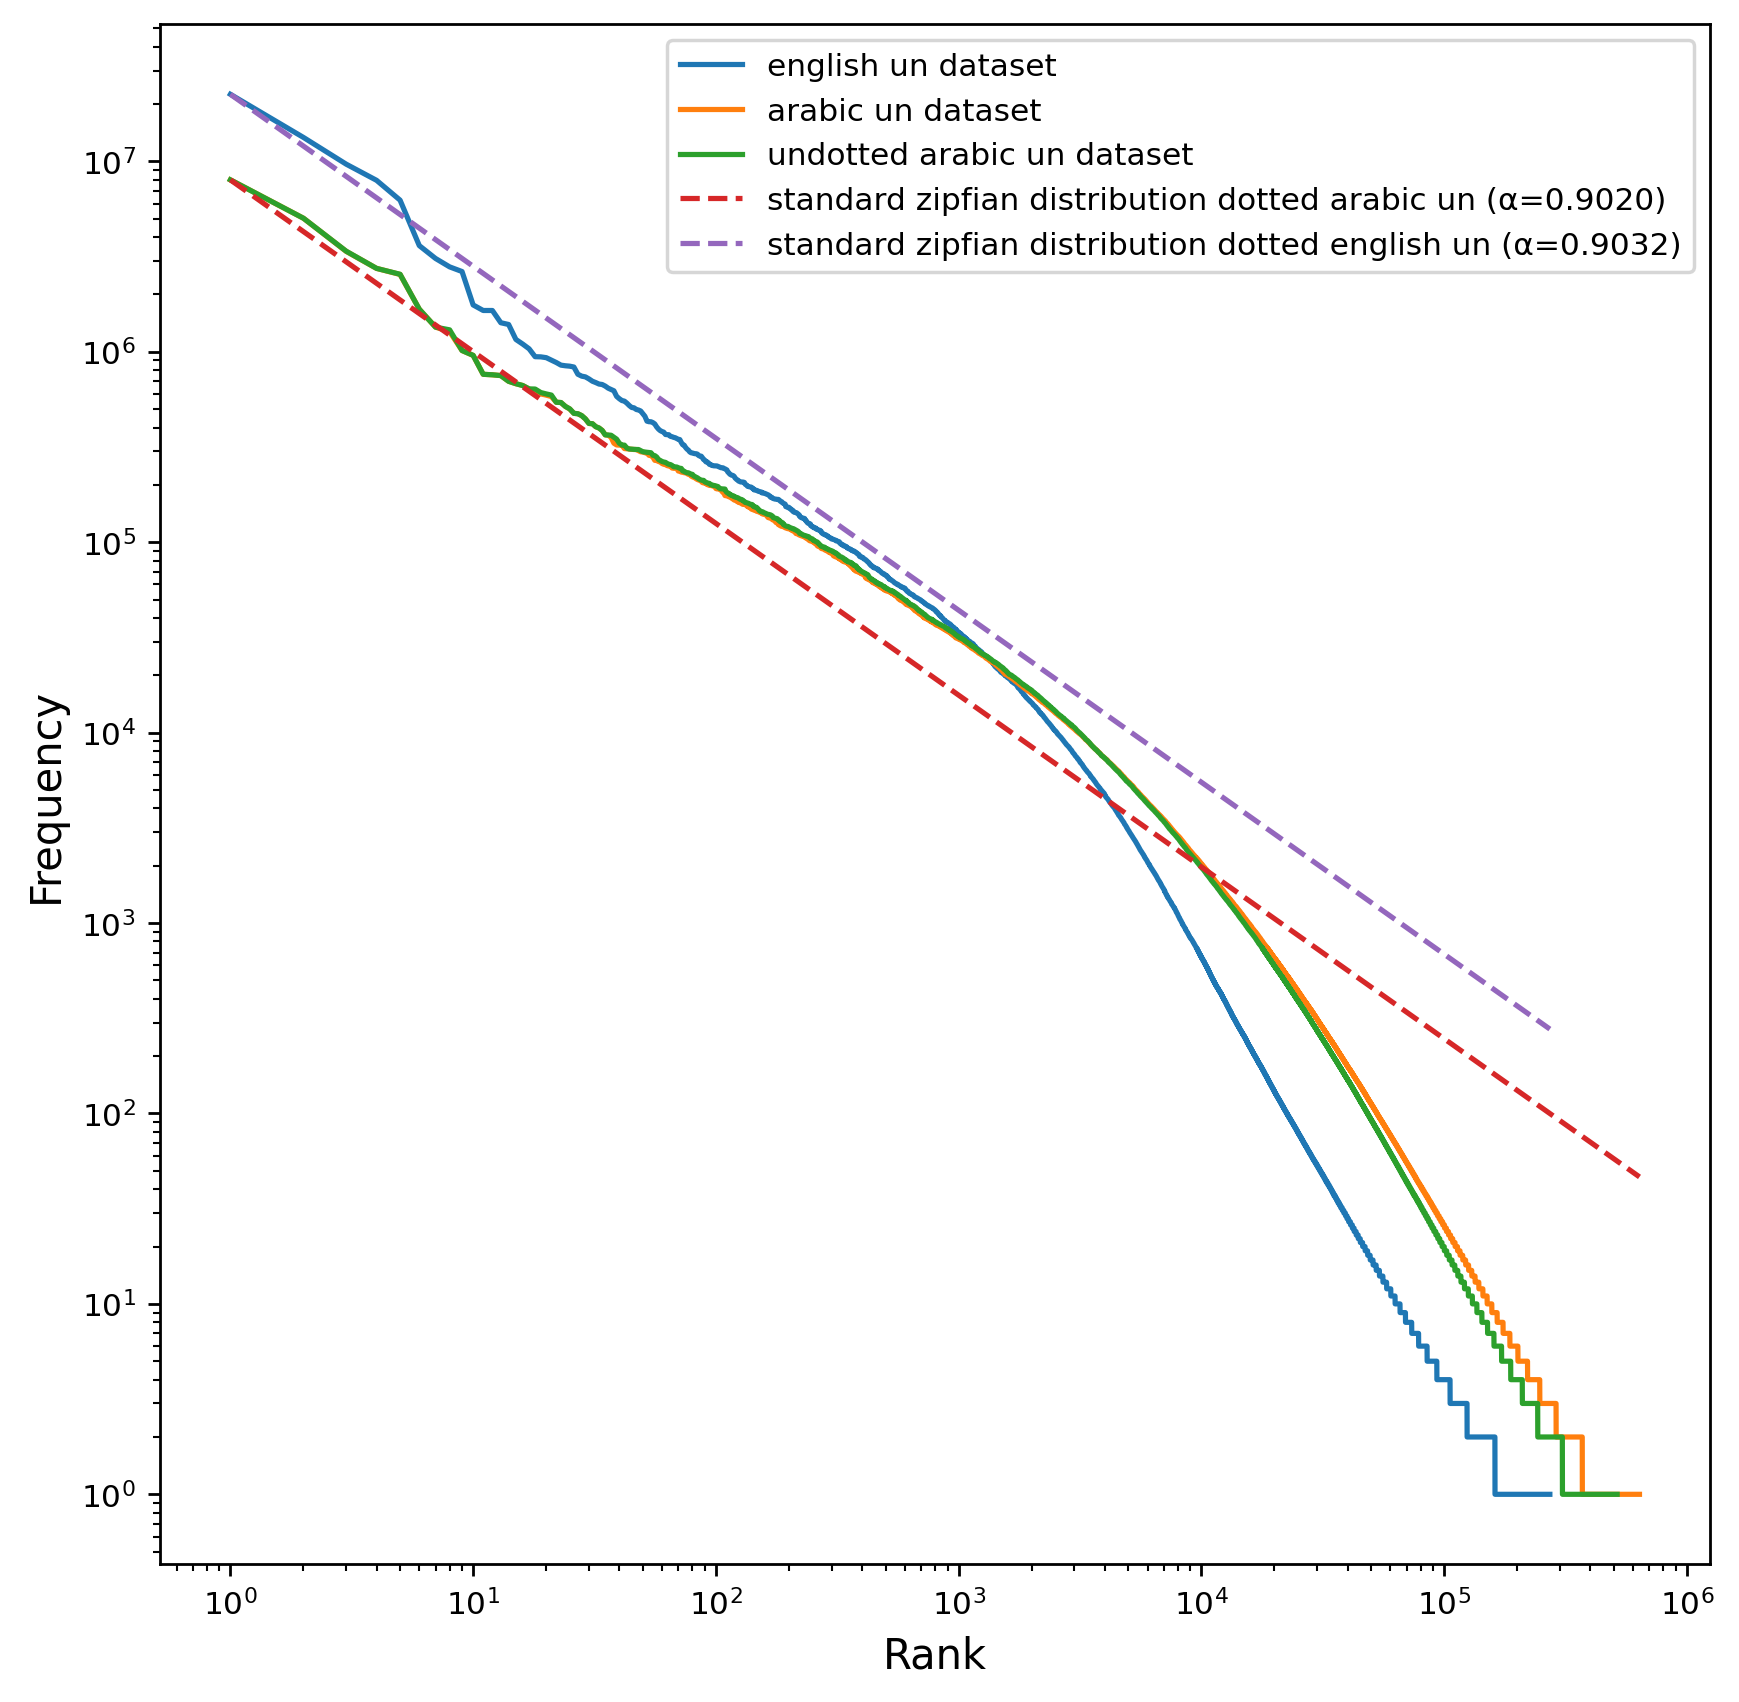

In [37]:
plot_zipf()

In [38]:
def plot_heaps(figsize=(8,8),fontsize=9):
    unlog = lambda points: list(map(lambda point: 10**point, points))

    plt.figure(figsize=figsize,dpi=250)

    for i, dataset_name in enumerate(("english_un", "arabic_un", "undotted_arabic_un")):
        X, Y = (
            globals()[f"{dataset_name}_heaps_X"],
            globals()[f"{dataset_name}_heaps_Y"],
        )

        k, b = (
            globals()[f"{dataset_name}_heaps_k"],
            globals()[f"{dataset_name}_heaps_beta"],
        )

        plt.plot(unlog(X), unlog(Y), label=f"{dataset_name} dataset (k={k:.3f},β={b:.3f})")
        # https://stackoverflow.com/a/41308516/4412324
        # plt.text(
        #     x=0.50,
        #     y=(-i * 0.02 + 0.95),
        #     s=f"{dataset_name}: k={k:.3f},β={b:.3f}",
        #     transform=plt.gca().transAxes,
        #     fontsize=12,
        # )
        
    plt.xlabel("Running Text (N)", fontsize=fontsize+3) # the font needs to be a bit larger
    plt.ylabel("Vocabulayr (V)", fontsize=fontsize+3) # the font needs to be a bit larger

    plt.legend(loc="upper left")
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.rc("font", size=fontsize)

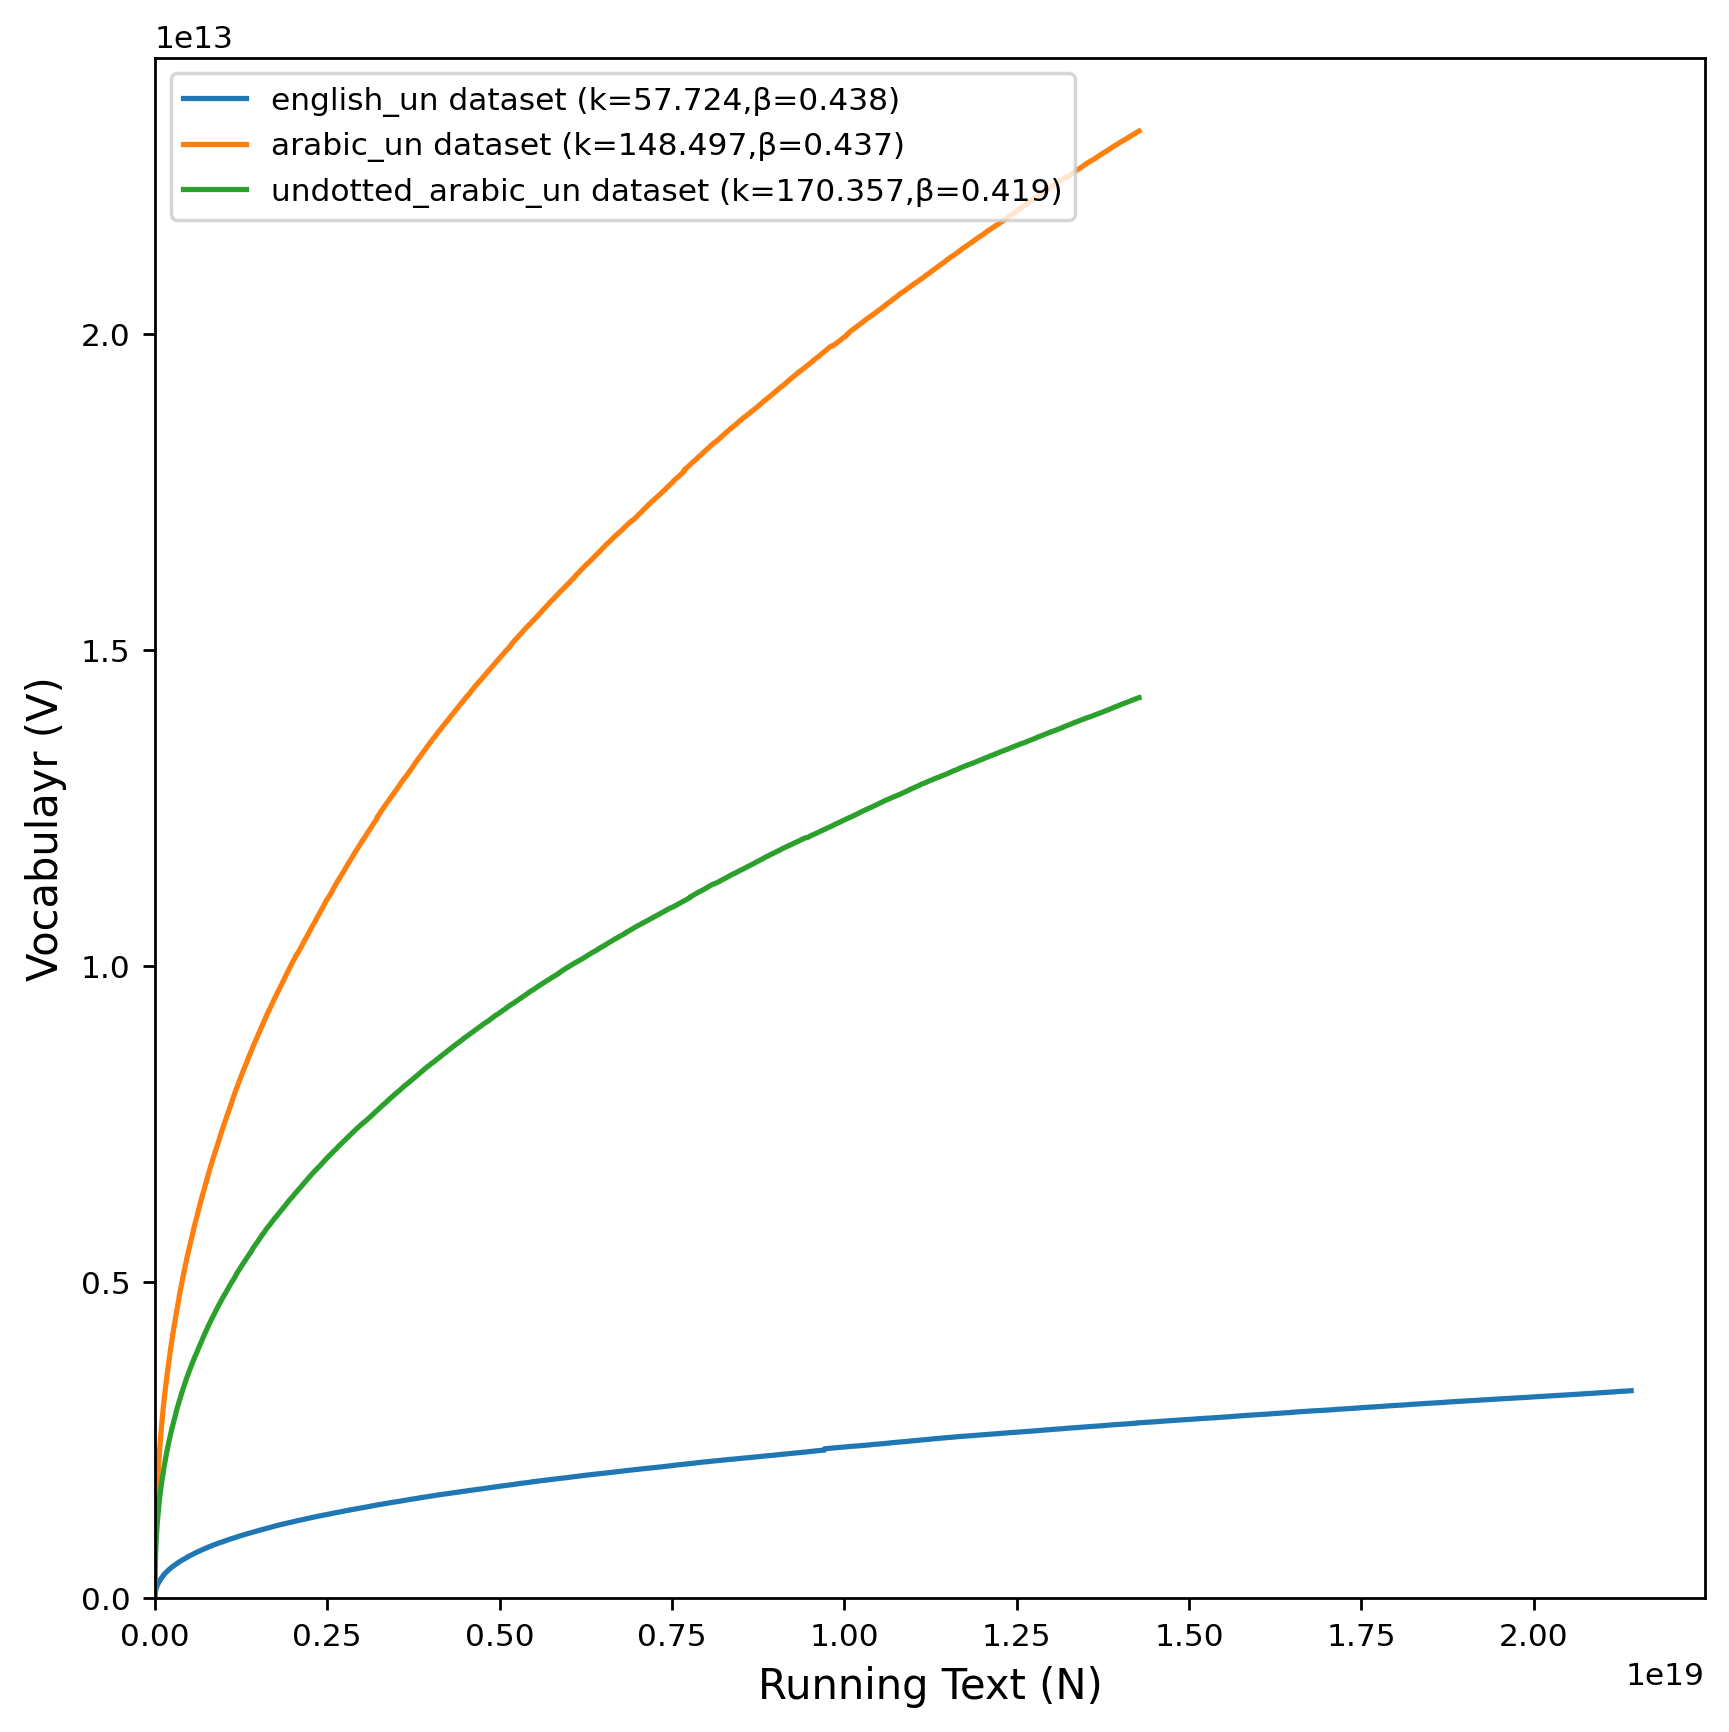

In [39]:
plot_heaps()